In [158]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import os
import numpy as np
from datetime import datetime

#"""
# The function "process_file" read a file from target document and return the parsed text in a piece of dataframe
# param: filename(e.g. "ADgvtzOv"), address: the document address
# return: a piece of dataframe with 13 attributes (fileName, companyName, Report_type, total number of cancelled ordinary shares,
#         total number of shares in issues, USD low price per share, USD average price per share, USD high price per share, 
#         EUR low price per share, EUR average price per share, EUR high price per share, announce Date of cancellation and 
#         released date of report)

def process_file(filename, address):
    # read file
    load_file = address+filename
    print("Processing file in {}".format(load_file))
    
    with open(load_file, 'r') as f:
        # using Beautiful package to parse HTML file
        soup = BeautifulSoup(f, 'html.parser')
        
        # check the file with HTML tag
        if soup.find("html"):
                      
            # find released datetime
            # Since the released date and report type are stored in the same tags for all the files
            # use find tag to search target text  
            released_date_part = soup.find("div", {"class": "marketnews-released"})
            # transform to datetime type
            released_date = datetime.strptime(released_date_part.text[9:], '%H:%M %d-%b-%Y') if released_date_part else None
    
            # find report type
            report_type_part = soup.find("div", {"class":"marketnews-h1"})
            report_type = report_type_part.text if report_type_part else None
            
            # initial
            USD = []
            EUR = []
            cancel_date = None
            cancellation_share_num = None
            share_in_issue_num = None 
            company_name = None
            
            # CSS selector for finding the target paragraph
            content_part = soup.select("#fullcontainer div p")

            for term in content_part: 
                # find cancel date
                # using regular expression to find target words
                check = re.findall('today announces that on.*?it', term.text)
                if check:  
                    check_2 = re.findall("\d.*?\s\w*[,\s]+\d*", check[0])
                    # replace "," in the date text
                    cancel_date = check_2[0].replace(",","") if check_2 else None
                    
                    # avoid "th" such words
                    date_check = cancel_date.split(" ")
                    if len(date_check[0])>2:
                        date_check[0] =  re.search(r'\d+', date_check[0]).group()
                        cancel_date = " ".join(date_check)
                        cancel_date = datetime.strptime(cancel_date, '%d %B %Y')
                    else:
                        cancel_date = datetime.strptime(cancel_date, '%d %B %Y')


                # find number of cancellation share
                check_3 = re.findall("cancellation a total of .*?[\,|\.]\d\d\d", term.text)
                if check_3:
                    check_4 = re.findall("\d*,\d*",check_3[0])
                    cancellation_share_num = float(check_4[0].replace(",","")) if check_4 else None
            

                # find number of Ordinary Shares in issue
                check_5 = re.findall("have.*?Ordinary Shares in issue", term.text)
                if check_5:
                    check_6 = re.findall("\d*,\d\d\d,\d\d\d,\d\d\d", check_5[0])
                    share_in_issue_num = float(check_6[0].replace(",","")) if check_6 else None     

                # find the price of shares
                check_7 = re.findall("[€$]\d\d\.\d\d*", term.text)
                if check_7:
                    for item in check_7:
                        if "€" in item:
                            EUR.append(item[1:])
                        if "$" in item:
                            USD.append(item[1:])
                            
                # find the company name
                check_8 = re.findall(".*?\(the\s\"Company", term.text)
                if check_8:
                    company_name = check_8[0][:-14]

            # sort the array to confirm the low, average, high price
            USD = sorted(USD)
            EUR = sorted(EUR)
            
            # avoid non value
            if len(USD) == 1:
                USD_temp = [None] * 3
                USD_temp[1] = USD[0]
                USD = USD_temp
            elif len(USD) == 0:
                USD = [None]*3
            else:
                pass

            if len(EUR) == 1:
                EUR_temp = [None] * 3
                EUR_temp[1] = EUR[0]
                EUR = EUR_temp
            elif len(EUR) == 0:
                EUR = [None]*3
            else:
                pass
            
            #add an instance of this file
            df_each = pd.DataFrame({"fileName":[filename], "companyName":company_name ,"Report_type":[report_type], "ShareCancelNum":[cancellation_share_num], "ShareIssueNum":[share_in_issue_num], \
                                   "usdLow":[USD[0]], "usdAverage":[USD[1]], "usdHigh":[USD[2]], "eurLow":[EUR[0]], "eurAverage":[EUR[1]], "eurHigh":[EUR[2]], "announceDate":[cancel_date], \
                                   "releaseDate":[released_date]})
      
            return df_each
    
        else:
            # avoid non-HTML file
            print("Not HTML file. Please check the file {}.".format(filename))
            return None

In [159]:
# construct a dataframe to store all the parsed information.
df = pd.DataFrame(columns =  ["fileName", "companyName", "Report_type", "ShareCancelNum", "ShareIssueNum", "usdLow", \
                                    "usdAverage", "usdHigh", "eurLow", "eurAverage", "eurHigh", "announceDate", \
                                    "releaseDate"])

for filename in os.listdir(os.getcwd()+"\\"+"data_"):
    address = os.getcwd()+"\\"+"data_"+"\\"
    df_ = process_file(filename, address)
    if df_ is not None:
        print("File: {} done!".format(filename))
        df = df.append(df_)   
    else:
        print("Processing Error!!!")   

Processing file in C:\Users\alien\Desktop\Bloomberg\data_\aALwUTVP
File: aALwUTVP done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\ADgvtzOv
File: ADgvtzOv done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\AeyAvwbS
File: AeyAvwbS done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\afxrbsGr
File: afxrbsGr done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\aOXXVvgp
File: aOXXVvgp done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\AQSTubrQ
File: AQSTubrQ done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\ASoZgUGZ
File: ASoZgUGZ done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\aVaOhBxY
File: aVaOhBxY done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\avydCPha
File: avydCPha done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\axebwvHk
File: axebwvHk done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\ayuMTszA
File: ayuMTszA done!
Processing file in C:\Users\alie

File: IuQzUNoX done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\IZVSGTJh
File: IZVSGTJh done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\IZwmBbrZ
File: IZwmBbrZ done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\jaOKPWMx
File: jaOKPWMx done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\JcmrInId
File: JcmrInId done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\JcVFdVLt
File: JcVFdVLt done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\JDcNEBeZ
File: JDcNEBeZ done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\JdivAjOL
File: JdivAjOL done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\jDpYhzhJ
File: jDpYhzhJ done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\jJCECnwL
File: jJCECnwL done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\jnCRumYF
File: jnCRumYF done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\JQnsJPYn
File: JQnsJPYn done!
Processing 

Processing file in C:\Users\alien\Desktop\Bloomberg\data_\tJSgVKPj
File: tJSgVKPj done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\TtuBtVow
File: TtuBtVow done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\TTWFKeJn
File: TTWFKeJn done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\ttZjbdDv
File: ttZjbdDv done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\ucgtflOy
File: ucgtflOy done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\UoWcahGf
File: UoWcahGf done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\UQSsuwmj
File: UQSsuwmj done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\UVFImOCB
File: UVFImOCB done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\uyZrfSOc
File: uyZrfSOc done!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\vAJpAaDA
Not HTML file. Please check the file vAJpAaDA.
Processing Error!!!
Processing file in C:\Users\alien\Desktop\Bloomberg\data_\VAZFHlfV
File: V

In [160]:
df.set_index('fileName', inplace = True)

In [161]:
# analysis the data
df.describe(include='all')

,companyName,Report_type,ShareCancelNum,ShareIssueNum,usdLow,usdAverage,usdHigh,eurLow,eurAverage,eurHigh,announceDate,releaseDate
count,262,262,261.000000,2.610000e+02,90,92,90,250,258,250,261,262
unique,1,3,NaN,NaN,89,92,87,229,256,229,258,260
top,Ryanair Holdings plc,Transaction in Own Shares,NaN,NaN,16.6820,16.6026,16.86,14.00,13.9732,18.4500,2017-02-08 00:00:00,2016-05-31 07:00:00
freq,262,260,NaN,NaN,2,1,2,3,2,3,2,2
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-05 00:00:00,2015-08-05 17:57:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-08 00:00:00,2018-02-09 07:00:00
mean,NaN,NaN,311265.582375,1.246707e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,180319.664152,4.272316e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1162.000000,1.181734e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,217600.000000,1.208465e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
# three different type of report
df["Report_type"].unique()

array(['Transaction in Own Shares', 'Share buy-back programme',
       'Transaction in Own Shares - Replacement'], dtype=object)

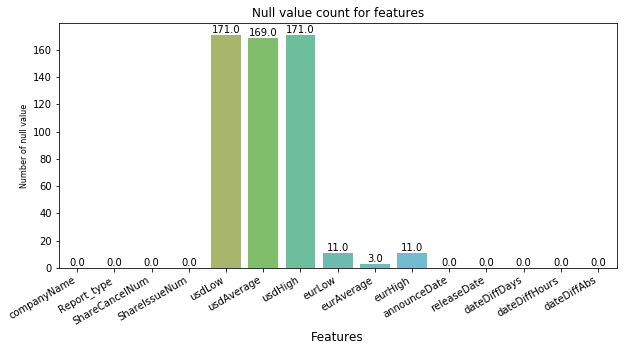

In [188]:
# check the count of nan value
df.isnull().sum()

import seaborn as sns
df = df.sort_values(by='dateDiffAbs')
count  = df.isnull().sum()
plt.figure(figsize=(10,5))
ax = sns.barplot(count.index, count.values, alpha=0.8)
plt.title('Null value count for features')
plt.ylabel('Number of null value', fontsize=8)
plt.xlabel('Features', fontsize=12)
plt.gcf().autofmt_xdate() 

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:0.1f}'.format(y), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

plt.show()

In [164]:
df[df["ShareCancelNum"].isnull()]

,companyName,Report_type,ShareCancelNum,ShareIssueNum,usdLow,usdAverage,usdHigh,eurLow,eurAverage,eurHigh,announceDate,releaseDate
fileName,,,,,,,,,,,,
cqjqfHzE,Ryanair Holdings plc,Share buy-back programme,NaN,NaN,None,None,None,None,None,None,NaT,2018-02-06 07:15:00


In [165]:
df[df["announceDate"].isnull()]

,companyName,Report_type,ShareCancelNum,ShareIssueNum,usdLow,usdAverage,usdHigh,eurLow,eurAverage,eurHigh,announceDate,releaseDate
fileName,,,,,,,,,,,,
cqjqfHzE,Ryanair Holdings plc,Share buy-back programme,NaN,NaN,None,None,None,None,None,None,NaT,2018-02-06 07:15:00


In [166]:
# since the announceDate relevant to the result of prediction. 
# remove all the missing label data
df = df.dropna(subset=['announceDate'], how="any")

In [167]:
df.isnull().sum()

companyName         0
Report_type         0
ShareCancelNum      0
ShareIssueNum       0
usdLow            171
usdAverage        169
usdHigh           171
eurLow             11
eurAverage          3
eurHigh            11
announceDate        0
releaseDate         0
dtype: int64

In [168]:
# transfer the question to predict the date interval from the announce date to released date

df['dateDiffDays'] = (df['releaseDate']-df['announceDate'])  / np.timedelta64(1, 'D')
df['dateDiffHours'] = (df['releaseDate']-df['announceDate'])  / np.timedelta64(1, 'h')

In [169]:
df.sort_values(by='dateDiffDays')

,companyName,Report_type,ShareCancelNum,ShareIssueNum,usdLow,usdAverage,usdHigh,eurLow,eurAverage,eurHigh,announceDate,releaseDate,dateDiffDays,dateDiffHours
fileName,,,,,,,,,,,,,,
JzTGamJm,Ryanair Holdings plc,Transaction in Own Shares,242700.0,1.239779e+09,16.812,16.9132,16.99,14.36,14.57,14.70,2016-12-12,2016-12-12 07:00:00,0.291667,7.000000
mLgkxgmP,Ryanair Holdings plc,Transaction in Own Shares,230800.0,1.235675e+09,None,None,None,14.61,14.7746,14.95,2016-12-23,2016-12-23 14:00:00,0.583333,14.000000
xtcHKjNk,Ryanair Holdings plc,Transaction in Own Shares,192740.0,1.353150e+09,None,None,None,None,12.6737,None,2015-08-14,2015-08-14 17:02:00,0.709722,17.033333
hnRJrSMx,Ryanair Holdings plc,Transaction in Own Shares,586309.0,1.192868e+09,None,None,None,17.86,18.0038,18.07,2017-08-25,2017-08-25 17:18:00,0.720833,17.300000
YFsKXosC,Ryanair Holdings plc,Transaction in Own Shares,496500.0,1.216091e+09,None,None,None,18.0600,18.1353,18.2300,2017-06-05,2017-06-05 17:24:00,0.725000,17.400000
ucgtflOy,Ryanair Holdings plc,Transaction in Own Shares,194045.0,1.208271e+09,None,None,None,18.4200,18.6097,18.7600,2017-06-26,2017-06-26 17:27:00,0.727083,17.450000
JcVFdVLt,Ryanair Holdings plc,Transaction in Own Shares,50000.0,1.198549e+09,None,None,None,17.8400,18.0599,18.4400,2017-07-28,2017-07-28 17:27:00,0.727083,17.450000
aALwUTVP,Ryanair Holdings plc,Transaction in Own Shares,191000.0,1.354114e+09,None,None,None,None,12.8164,None,2015-08-07,2015-08-07 17:28:00,0.727778,17.466667
YSJLHvFp,Ryanair Holdings plc,Transaction in Own Shares,191200.0,1.353922e+09,None,None,None,None,12.8098,None,2015-08-10,2015-08-10 17:28:00,0.727778,17.466667


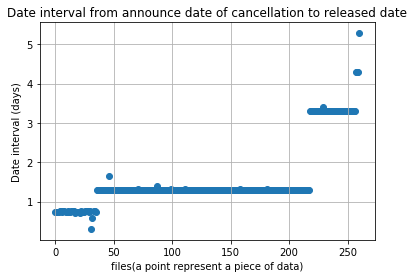

In [190]:
# plot
# The date interval value is very regular
import matplotlib.pyplot as plt
plt.scatter(range(df.shape[0]), df['dateDiffDays'])
plt.xlabel('files(a point represent a piece of data)')
plt.ylabel('Date interval (days)')
plt.title('Date interval from announce date of cancellation to released date')
plt.grid(True)
plt.show()

In [171]:
# release date
# to make the date intercal simple
df['dateDiffAbs'] = df['dateDiffHours'] // 24

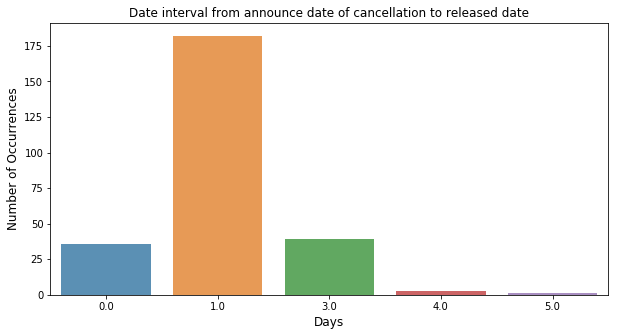

In [172]:
# In the figure, we can easily get the result
# The most likely future release date is the day after the company announce the cancellation. 
import seaborn as sns
df = df.sort_values(by='dateDiffAbs')
count  = df['dateDiffAbs'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(count.index, count.values, alpha=0.8)
plt.title('Date interval from announce date of cancellation to released date')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Days', fontsize=12)
plt.show()

In [173]:
# dataset: 
# input features: ShareCancelNum, ShareIssueNum, eurLow, eurAverage, eurHigh
# label: dateDiffAbs (Date interval in integer)
dataset_ = df[['ShareCancelNum', 'ShareIssueNum', 'eurLow', 'eurAverage', 'eurHigh', 'dateDiffAbs']].copy()
dataset_.dropna(how='any', inplace=True)
dataset_[['eurLow', 'eurAverage', 'eurHigh']] = dataset_[['eurLow', 'eurAverage', 'eurHigh']].astype(float)
df_train = dataset_.iloc[:,:-1]
df_test = dataset_.iloc[:,-1]


In [174]:
# use simple support vector classification to predict 
# although the dataset is too small and its seems the information of share not relevant to the date interval.
from sklearn.svm import SVC
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df_train, df_test, test_size=0.2, random_state=99)

clf = SVC(gamma='auto')
clf.fit(X_train, Y_train)
print("Accuracy Score: ", accuracy_score(clf.predict(X_test), Y_test))

Accuracy Score:  0.82
